In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Data Cleaning

In [33]:
path = r'data\ga_sessions.csv'
file = pd.read_csv(path)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
file.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [35]:
# посчитаем дубликаты в датасете
file.duplicated().sum()

0

In [36]:
# посмотрим, сколько процентов пропущенных значений в столбцах
missing_values = ((file.isna().sum() / len(file)) * 100).sort_values()
missing_values

session_id                   0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_country                  0.000000
utm_medium                   0.000000
geo_city                     0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
utm_source                   0.005215
utm_campaign                11.806346
utm_adcontent               18.043410
device_brand                19.740307
device_os                   57.533002
utm_keyword                 58.174009
device_model                99.121633
dtype: float64

In [37]:
# перед очисткой датасета создадим его копию
file_clean = file.copy()

In [38]:
# удалим столбцы с процентом пропущенных значений больше 50
file_clean.drop(columns=['device_model','utm_keyword','device_os'], inplace = True)

In [39]:
# проанализируем пропуски в столбце device_brand
# посмотрим, какой браузер для пустых значений
file_clean[file_clean.device_brand.isna()][['device_browser']].value_counts()

device_browser                  
Chrome                              215719
YaBrowser                            60374
Safari                               40955
Opera                                18024
Edge                                 16063
Firefox                              14582
Mozilla Compatible Agent               362
Samsung Internet                       323
[FBAN                                  268
Instagram 208.0.0.32.135 Android       140
Instagram 209.0.0.21.119 Android       111
MRCHROME                                77
Internet Explorer                       26
Android                                 22
Instagram 216.1.0.21.137 Android        19
Maxthon                                 18
(not set)                               17
Instagram 194.0.0.36.172 Android        15
Instagram 202.0.0.37.123 Android        12
Puffin                                   8
Instagram 212.0.0.38.119 Android         6
Mozilla                                  6
helloworld           

In [40]:
# посмотрим, с каких девайсов в основном пользуются браузером Safari
file_clean.loc[file_clean['device_browser'] == 'Safari']['device_brand'].value_counts()

Apple        437591
(not set)        10
Nokia             5
Microsoft         1
Name: device_brand, dtype: int64

In [41]:
# т.к. Safari в основном используется на девайсах Apple, заменим пропуски в device_brand на Apple в тех строках, где file_clean['device_browser'] == 'Safari'
m = file_clean['device_browser'] == 'Safari'
file_clean.loc[m, 'device_brand'] = file_clean.loc[m, 'device_brand'].replace(np.nan, 'Apple')

In [42]:
# посмотрим, с каких девайсов в основном пользуются браузером Samsung Internet
file_clean.loc[file_clean['device_browser'] == 'Samsung Internet']['device_brand'].value_counts()

Samsung      46324
(not set)      332
Xiaomi         149
Huawei          91
Realme          27
OnePlus         18
Asus             6
Nokia            6
OPPO             5
Google           5
Meizu            4
ZTE              3
Motorola         2
Ulefone          2
Vivo             2
Lenovo           2
Infinix          2
LeEco            2
Philips          1
DOOGEE           1
Tecno            1
Blackview        1
Name: device_brand, dtype: int64

In [43]:
# т.к. Samsung Internet в основном используется на девайсах Samsung, заменим пропуски в device_brand на Samsung в тех строках, где file_clean['device_browser'] == 'Samsung Internet'
n = file_clean['device_browser'] == 'Samsung Internet'
file_clean.loc[n, 'device_brand'] = file_clean.loc[n, 'device_brand'].replace(np.nan, 'Samsung')

In [44]:
# заменим остальные пропуски в device_brand на 'other'
file_clean.device_brand = file_clean.device_brand.fillna('other') 

In [45]:
missing_values = ((file_clean.isna().sum() / len(file_clean)) * 100).sort_values()
missing_values

session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_medium                   0.000000
device_category              0.000000
device_brand                 0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
utm_source                   0.005215
utm_campaign                11.806346
utm_adcontent               18.043410
dtype: float64

In [46]:
# т.к. столбаца utm_adcontent нет в описании данных, удалим этот столбец
file_clean.drop(columns=['utm_adcontent'], inplace = True)

In [47]:
# удалим оставшийся строки с незаполненными значениями
file_clean = file_clean.dropna()

In [48]:
missing_values = ((file_clean.isna().sum() / len(file_clean)) * 100).sort_values()
missing_values

session_id                  0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
dtype: float64

In [49]:
# далее необходимо в наш датасет добавить столбец с целевой переменной
# целевую переменную сформулируем из датасета ga_hits.csv
path_hits = r'data\ga_hits.csv'
hits = pd.read_csv(path_hits)
hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [50]:
# создадим датасет с колонкой session_id из ga_hits, т.к. по этому признаку далее мы будем объединять 2 датасета
hits_target = hits[['session_id']]

In [51]:
hits_target.head()

,session_id
0,5639623078712724064.1640254056.1640254056
1,7750352294969115059.1640271109.1640271109
2,885342191847998240.1640235807.1640235807
3,142526202120934167.1640211014.1640211014
4,3450086108837475701.1640265078.1640265078


In [52]:
# создадим массив ивентов, которые являются целевым действием
target = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click']

In [53]:
# добавим в новый датасет колонку, где будет 0, если этому session_id соответсвует не целевое действие и 1, если совершено целевое действие
hits_target['target'] = np.where(hits['event_action'].isin(target), 1, 0)

<ipython-input-53-034e28da4e4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits_target['target'] = np.where(hits['event_action'].isin(target), 1, 0)


In [54]:
hits_target.head()

,session_id,target
0,5639623078712724064.1640254056.1640254056,0
1,7750352294969115059.1640271109.1640271109,0
2,885342191847998240.1640235807.1640235807,0
3,142526202120934167.1640211014.1640211014,0
4,3450086108837475701.1640265078.1640265078,0


In [55]:
hits_target.target.value_counts()

0    15621562
1      104908
Name: target, dtype: int64

In [56]:
#объединяем два датасета по признаку session_id
df = file_clean.merge(hits_target)

In [57]:
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0
2,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0
3,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
4,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0


In [58]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()
missing_values

session_id                  0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
target                      0.0
dtype: float64

In [59]:
# проверим, сколкьо дубликатов по сессиям есть в датасете
df.duplicated(subset=['session_id']).value_counts()

True     11948743
False     1536903
dtype: int64

In [60]:
# отсортируем датасет по убыванию значений колонки target, чтобы при удалении дубликатов по session_id удалялись строки с target= 0
# и удалим дубликаты по колонке session_id
df = df.sort_values('target', ascending=False).drop_duplicates('session_id').sort_index()

In [61]:
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0
2,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0
3,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
37,9055447192389856083.1622453074.1622453074,2108385598.162245,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,mobile,Apple,375x812,Safari,Russia,Saint Petersburg,0
78,9055455318486370642.1640843788.1640843788,2108387490.164084,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,tablet,Lenovo,602x1029,YaBrowser,Russia,Saint Petersburg,0


## Feature Engineering

In [62]:
# перед работай с фичами, скопируем наш датасет
df_features = df.copy()

In [63]:
# посомтрим, сколько уникальных значений в каждом столбце датасета
unique_counts = pd.DataFrame.from_records([(col, df_features[col].nunique()) for col in df_features.columns],
                                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
14,target,2
8,device_category,3
6,utm_medium,50
11,device_browser,53
12,geo_country,156
9,device_brand,199
2,visit_date,226
5,utm_source,278
7,utm_campaign,406
4,visit_number,430


In [64]:
# необходимо сократить количсевто уникальных значений в колонках, котоыре станут категориальными признаками
# посмотрим на значения колонки geo_country
df_features.geo_country.value_counts()

Russia                 1491631
Ukraine                   8081
United States             7409
Belarus                   3070
Kazakhstan                1983
                        ...   
Paraguay                     1
New Caledonia                1
Burundi                      1
Yemen                        1
Congo - Brazzaville          1
Name: geo_country, Length: 156, dtype: int64

In [65]:
# т.к. сервис Автоподписки работает только с клиентами из России, все остальные страны замеим на 'other'
df_features.loc[df_features['geo_country'] != 'Russia', 'geo_country'] = 'other'

In [66]:
df_features.geo_country.value_counts()

Russia    1491631
other       45272
Name: geo_country, dtype: int64

In [67]:
# обработаем колонку 'device_screen_resolution'
# чтобы перевести эту фичу в числовой формат, разобъем эту колонку на два значения: 'screen_width' и 'screen_height'
# и присвоим новым колонкам тип int
df_features[['screen_width', 'screen_height']] = df.device_screen_resolution.str.split('x', expand = True).astype(int)

In [68]:
# удалим исходную колонку 'device_screen_resolution'
df_features.drop(columns=['device_screen_resolution'], inplace=True)

In [69]:
# предположительно, ширина и длина экрана будут коррелировать между собой, проверим это
df_features.corr()

,visit_number,target,screen_width,screen_height
visit_number,1.000000,0.016271,0.123272,0.037630
target,0.016271,1.000000,0.005902,0.009228
screen_width,0.123272,0.005902,1.000000,0.527991
screen_height,0.037630,0.009228,0.527991,1.000000


In [70]:
# т.к. колонки 'screen_width' и 'screen_height' коррелируют между собой, рассчитаем по ним один признак: диагональ экрана 
df_features['diagonal'] = np.sqrt(df_features.screen_width**2 + df_features.screen_height**2)

In [71]:
df_features['diagonal'].value_counts()

987.021783     133266
937.363323     105964
2202.907170     97951
894.409861      91132
859.069264      82709
                ...  
1046.721071         1
811.510320          1
1087.494828         1
911.004940          1
1215.082302         1
Name: diagonal, Length: 4432, dtype: int64

Text(0, 0.5, 'Диагональ экрана')

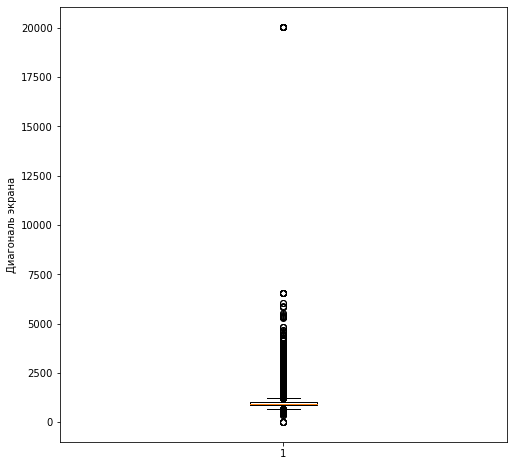

In [72]:
# посмотрим, есть ли выбросы в 'diagonal'
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df_features.diagonal)
ax.set_ylabel('Диагональ экрана')

In [73]:
# напишем функцию определения границ диапазона без выбросов
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [74]:
# рассчитаем количсество выбросов в колонке 'diagonal'
boundaries = calculate_outliers(df_features.diagonal)
up_outlier = (df_features.diagonal > boundaries[1])
down_outlier  = (df_features.diagonal < boundaries[0])           
print(f'В колонке diagonal {up_outlier.sum()} выбросов вверх')
print(f'В колонке diagonal {down_outlier.sum()} выбросов вниз')              

В колонке diagonal 294679 выбросов вверх
В колонке diagonal 2557 выбросов вниз


In [75]:
# заменим выбросы на крайние значения
df_features.loc[up_outlier, 'diagonal'] = int(boundaries[1])
df_features.loc[down_outlier, 'diagonal'] = int(boundaries[0])

Text(0, 0.5, 'Диагональ экрана')

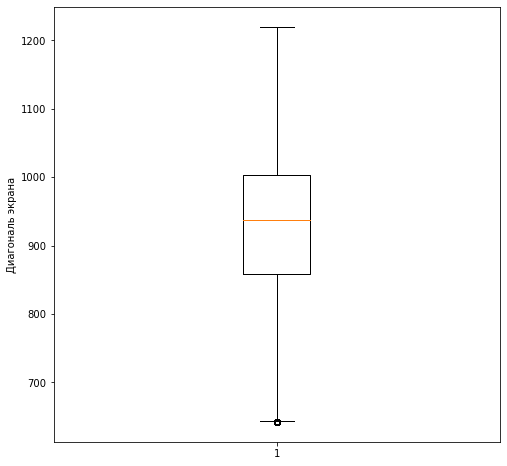

In [76]:
# убедимся, что выбросов в колонке 'diagonal' не осталось
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df_features.diagonal)
ax.set_ylabel('Диагональ экрана')

In [77]:
# удалим исходные столбцы 'screen_width', 'screen_height'
df_features.drop(columns=['screen_width', 'screen_height'], inplace=True)

In [78]:
# преобразуем колонку 'visit_date' в формат datetime
df_features['visit_date'] = pd.to_datetime(df_features['visit_date'])

In [79]:
# введем признак 'day_of_year' вместо даты
df_features['day_of_year'] = df_features['visit_date'].dt.dayofyear

In [80]:
# удалим исходный столбец 'visit_date'
df_features.drop(columns=['visit_date'], inplace=True)

In [81]:
# обоработаем колонку 'visit_time'
# разделим дату на три новых колонки: 'hour', 'minute', 'second'
# и присвоим новым колонкам тип int
df_features[['hour', 'minute', 'second']] = df_features.visit_time.str.split(':', expand = True).astype(int)

In [82]:
# сделаем одну информативную фичу 'total_seconds' по данным колонок 'hour', 'minute', 'second'
df_features['total_seconds'] = df_features.second + df_features.minute * 60 + df_features.hour * 60 *60

In [83]:
# удалим уже ненужные колонки 'visit_time', 'hour', 'minute', 'second'
df_features.drop(columns=['visit_time', 'hour', 'minute', 'second'], inplace = True)

In [84]:
df_features.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,device_category,device_brand,device_browser,geo_country,geo_city,target,diagonal,day_of_year,total_seconds
0,9055434745589932991.1637753792.1637753792,2108382700.163776,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,Chrome,Russia,Zlatoust,0,804.984472,328,52592
2,905544597018549464.1636867290.1636867290,210838531.163687,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,mobile,Samsung,Samsung Internet,Russia,Moscow,0,936.771584,318,30090
3,9055446045651783499.1640648526.1640648526,2108385331.164065,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,Chrome,Russia,Krasnoyarsk,0,804.984472,362,9726
37,9055447192389856083.1622453074.1622453074,2108385598.162245,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,mobile,Apple,Safari,Russia,Saint Petersburg,0,894.409861,151,43200
78,9055455318486370642.1640843788.1640843788,2108387490.164084,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,tablet,Lenovo,YaBrowser,Russia,Saint Petersburg,0,1192.159805,364,32188


In [85]:
# названия городов из колонки 'geo_city' преобразуем в географические координаты
# посомтрим, значения принимает колонка 'geo_city'
df_features.geo_city.value_counts()

Moscow              642481
Saint Petersburg    237448
(not set)            63429
Yekaterinburg        32812
Krasnodar            29412
                     ...  
Torre del Mar            1
Shyroke                  1
Araure                   1
Kragujevac               1
Hagenow                  1
Name: geo_city, Length: 2312, dtype: int64

In [86]:
# видим значения '(not set)', которое интерпретируется как пустое значение
# посчитаем, сколько процентов от датасета со значением '(not set)' в колонке 'geo_city'
geo_city_not_set_number = ((len(df_features[df_features['geo_city'] == '(not set)']) / len(df_features)) * 100)
geo_city_not_set_number

4.1270659241344445

In [87]:
# т.к. значений '(not set)' в колонке 'geo_city' немного, около 4%, удалим эти строки из датасета
df_features.drop(df_features[df_features['geo_city'] == '(not set)'].index, inplace=True)

In [88]:
# для получения координат города используем бибилиотеку geopy
#!pip install geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [89]:
# функция для запроса координат по названию города
def get_coord(city):
    geolocator = Nominatim(user_agent="my_request")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    try:
        location = geolocator.geocode(city)
        if location:
            lat = geolocator.geocode(city).latitude
            lon = geolocator.geocode(city).longitude
            return lat, lon
        else:
            return 0, 0
    except:
        return 0, 0

In [90]:
# создадим пустые массивы для значений широты и долготы
# и будем вызывать функцию получения координат для всех уникальных значений из колонки 'geo_city'
latitude_array = []
longitude_array = []
for i in tqdm(range(len(df_features.geo_city.unique()))):
    city = df_features.geo_city.unique()[i]
    lat, lon = get_coord(city)
    latitude_array.append(lat)
    longitude_array.append(lon)

100%|██████████████████████████████████████████████████████████████████████████████| 2311/2311 [57:07<00:00,  1.48s/it]


In [92]:
# преобразуем полученный массив с широтой в словарь с ключами - названиями городов
latitude_dict = {df_features.geo_city.unique()[i]: latitude_array[i] for i in range(len(latitude_array))}

In [93]:
# преобразуем полученный массив с долготой в словарь с ключами - названиями городов
longitude_dict = {df_features.geo_city.unique()[i]: longitude_array[i] for i in range(len(longitude_array))}

In [94]:
# добавим в наш датасет столбцы 'latitude' и 'longitude' с долготой и широтой
df_features['latitude'] = df_features['geo_city'].map(latitude_dict)
df_features['longitude'] = df_features['geo_city'].map(longitude_dict)

In [95]:
df_features.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,device_category,device_brand,device_browser,geo_country,geo_city,target,diagonal,day_of_year,total_seconds,latitude,longitude
0,9055434745589932991.1637753792.1637753792,2108382700.163776,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,Chrome,Russia,Zlatoust,0,804.984472,328,52592,55.034639,59.529269
2,905544597018549464.1636867290.1636867290,210838531.163687,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,mobile,Samsung,Samsung Internet,Russia,Moscow,0,936.771584,318,30090,55.625578,37.606392
3,9055446045651783499.1640648526.1640648526,2108385331.164065,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,Chrome,Russia,Krasnoyarsk,0,804.984472,362,9726,56.009097,92.872515
37,9055447192389856083.1622453074.1622453074,2108385598.162245,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,mobile,Apple,Safari,Russia,Saint Petersburg,0,894.409861,151,43200,59.938732,30.316229
78,9055455318486370642.1640843788.1640843788,2108387490.164084,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,tablet,Lenovo,YaBrowser,Russia,Saint Petersburg,0,1192.159805,364,32188,59.938732,30.316229


In [96]:
# проваерим, для скольки строк не было найдено географических координат
len(df_features[df_features.latitude == 0])

3515

In [97]:
# как так таких строк немного относительно всего датасета, удалим их
df_features.drop(df_features[df_features['longitude'] == 0].index, inplace=True)

In [98]:
# удалим исходный столбец с названиями городов
df_features.drop(columns=['geo_city'], inplace = True)

In [99]:
# сократим количество уникальных значений в колонке 'utm_campaign'
# заменим значения, встречающиеся менее чем для 1% датасета, на 'other'
df_features.loc[df_features['utm_campaign'].map(df_features['utm_campaign'].value_counts(normalize=True).lt(0.01)), 'utm_campaign'] = 'other'

In [100]:
# сократим количество уникальных значений в колонке 'utm_source'
# заменим значения, встречающиеся менее чем для 1% датасета, на 'other'
df_features.loc[df_features['utm_source'].map(df_features['utm_source'].value_counts(normalize=True).lt(0.01)), 'utm_source'] = 'other'

In [101]:
# было замечено, что в колонке 'utm_source' есть значения '(none)', '(not set)'
# сделаем только '(not set)'
df_features.loc[df_features['utm_source'] == '(none)', 'utm_source'] = '(not set)'

In [102]:
# было замечено, что в колонке 'device_brand' есть значения '(not set)' м 'other'
# сделаем только 'other'
df_features.loc[df_features['device_brand'] == '(not set)', 'device_brand'] = 'other'

In [103]:
# посмотрим, какие значения принимает колонка 'device_browser'
pd.set_option("display.max_rows", None)
df_features.device_browser.value_counts()

Chrome                              828634
Safari                              363041
YaBrowser                            92013
Safari (in-app)                      58767
Android Webview                      45440
Samsung Internet                     39040
Opera                                18828
Firefox                              11770
Edge                                 10741
UC Browser                             663
Android Runtime                        232
Mozilla Compatible Agent               207
[FBAN                                  115
Instagram 208.0.0.32.135 Android        72
MRCHROME                                52
Instagram 209.0.0.21.119 Android        49
Puffin                                  36
Android Browser                         26
Internet Explorer                       20
Opera Mini                              19
Android                                 19
Maxthon                                 19
Instagram 202.0.0.23.119                17
Mozilla    

In [104]:
# все записи колонки 'device_browser', содержащие подстроку 'Instagram' заменим на 'Instagram'
df_features.loc[df_features['device_browser'].str.contains('Instagram'), 'device_browser'] = 'Instagram'

In [105]:
# сохраним итоговый датасет в файл
df_features.to_csv('df_features.csv', index=False)

## Нормализация данных и преобразование категориальных данных

In [2]:
df_prepared = pd.read_csv('df_features.csv')

NameError: name 'pd' is not defined

In [107]:
df_prepared.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,device_category,device_brand,device_browser,geo_country,target,diagonal,day_of_year,total_seconds,latitude,longitude
0,9055434745589932991.1637753792.1637753792,2.108383e+09,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,Chrome,Russia,0,804.984472,328,52592,55.034639,59.529269
1,905544597018549464.1636867290.1636867290,2.108385e+08,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,mobile,Samsung,Samsung Internet,Russia,0,936.771584,318,30090,55.625578,37.606392
2,9055446045651783499.1640648526.1640648526,2.108385e+09,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,mobile,Huawei,Chrome,Russia,0,804.984472,362,9726,56.009097,92.872515
3,9055447192389856083.1622453074.1622453074,2.108386e+09,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,mobile,Apple,Safari,Russia,0,894.409861,151,43200,59.938732,30.316229
4,9055455318486370642.1640843788.1640843788,2.108387e+09,1,other,cpc,FTjNLDyTrXaWYgZymFkV,tablet,Lenovo,YaBrowser,Russia,0,1192.159805,364,32188,59.938732,30.316229


In [5]:
# посмотрим тип колонок в датасете
df_prepared.dtypes

session_id          object
client_id          float64
visit_number         int64
utm_source          object
utm_medium          object
utm_campaign        object
device_category     object
device_brand        object
device_browser      object
geo_country         object
target               int64
diagonal           float64
day_of_year          int64
total_seconds        int64
latitude           float64
longitude          float64
dtype: object

In [18]:
# нормализуем числовые фичи при помощи StandardScaler
std_scaler = StandardScaler()
num_cols = ['visit_number', 'diagonal', 'day_of_year', 'total_seconds', 'latitude', 'longitude']
std_scaler.fit(df_prepared[num_cols])
std_scaler = std_scaler.transform(df_prepared[num_cols])
df_prepared[num_cols] = std_scaler

In [6]:
# преобразуем некоторые фичи в категориальные
cols = ['utm_source', 'utm_medium', 'utm_campaign', 'device_category', 'device_brand', 'device_browser', 'geo_country']
df_prepared[cols] = df_prepared[cols].apply(lambda x: x.astype('category'))

In [7]:
# преобразуем категориальные фичи с помощью OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(df_prepared[cols])
ohe_cols = ohe.transform(df_prepared[cols])
#ohe.categories_

In [8]:
# присоединм новые колонки, полученные из категориальных фичей, в датасет
df_prepared[ohe.get_feature_names()] = ohe_cols

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [25]:
# удалим исходные колонки с категориальными переменными 
df_prepared.drop(columns=cols, inplace=True)

In [ ]:
# удалим неинформативные колонки 'session_id', 'client_id'
df_features.drop(columns=['session_id', 'client_id'], inplace=True)

In [27]:
df_prepared.head()

,visit_number,target,diagonal,day_of_year,total_seconds,latitude,longitude
0,-0.129521,0,-0.963198,0.869949,0.117858,0.057561,0.924447
1,-0.129521,0,-0.095034,0.722134,-0.908212,0.159753,-0.130045
2,-0.129521,0,-0.963198,1.372520,-1.836792,0.226076,2.528261
3,-0.129521,0,-0.374097,-1.746380,-0.310408,0.905634,-0.480703
4,-0.129521,0,1.587368,1.402083,-0.812545,0.905634,-0.480703


## Modeling

In [13]:
#!pip install imbalanced-learn

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
# отделим целевую переменную в y
x = df_prepared.drop(['target'], axis=1)
y = df_prepared.target
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [16]:
# проверим сбалансированность выборки
y.value_counts()

0    1428914
1      41687
Name: target, dtype: int64

In [30]:
# выборка не сбалансирована, модели могут обучаться плохо на значениях '1'
# применим инструмент балансировки выборки путем уменьшения превалирующего класса
rus = RandomUnderSampler()
x_resampled, y_resampled = rus.fit_resample(x, y)

In [18]:
# снова проверим сбалансированность выборки 
y_resampled.value_counts()

0    41687
1    41687
Name: target, dtype: int64

In [19]:
# построим модель многослойного персептрона и рассчитаем кросс-валидацию по 'roc_auc'
# выведем среднее значение roc_auc и разброс
mlp = MLPClassifier(random_state=42, max_iter=500, early_stopping=True, activation='tanh')
cv_score = cross_val_score(mlp, x_resampled.values, y_resampled, cv=5, scoring ='roc_auc')
cv_score.mean(), cv_score.std()

(0.6908083330243681, 0.0025774712415977227)

In [20]:
clf = GradientBoostingClassifier()
cv_score = cross_val_score(clf, x_resampled.values, y_resampled, cv=5, scoring ='roc_auc')
cv_score.mean(), cv_score.std()

(0.6941592651498689, 0.003085227366950258)

In [21]:
clf.fit(x_resampled.values, y_resampled)
sorted(zip(x.columns, clf.feature_importances_))

[('day_of_year', 0.22423485722624747),
 ('diagonal', 0.014565690624729092),
 ('latitude', 0.01671872421239151),
 ('longitude', 0.02585714373823738),
 ('total_seconds', 0.01979614974114296),
 ('visit_number', 0.06335808651263601),
 ('x0_MvfHsxITijuriZxsqZqt', 0.0024026812384773024),
 ('x0_QxAxdyPLuQMEcrdZWdWb', 0.01267489144847705),
 ('x0_RmEBuqrriAfAVsLQQmhk', 0.01547451036380567),
 ('x0_ZpYIoDJMcFzVoPFsHGJL', 0.10931965063127036),
 ('x0_aXQzDWsJuGXeBXexNHjc', 1.618804065152325e-07),
 ('x0_bByPQxmDaMXgpHeypKSM', 0.06004765297545952),
 ('x0_fDLlAcSmythWSCVMvqvL', 0.01098536844141823),
 ('x0_jaSOmLICuBzCFqHfBdRg', 0.0010191719305628036),
 ('x0_kjsLglQLzykiRbcDiGcD', 0.0003507904311034661),
 ('x0_other', 0.032738118791918444),
 ('x0_vFcAhRxLfOWKhvxjELkx', 0.016355630546903366),
 ('x1_(none)', 0.009580112827527248),
 ('x1_(not set)', 0.00012876451509169514),
 ('x1_app', 0.001600095652708507),
 ('x1_article', 0.0),
 ('x1_banner', 0.0008727545455979683),
 ('x1_blogger_channel', 0.0),
 ('x1_b

In [31]:
# без категориальных фичей
clf = GradientBoostingClassifier()
cv_score = cross_val_score(clf, x_resampled.values, y_resampled, cv=5, scoring ='roc_auc')
cv_score.mean(), cv_score.std()

(0.6396912714216825, 0.0037331337474494296)

## Выводы

1. Исходя из анализа feature_importances_, можнно заключить, что модели любят числовые фичи больше, чем категориальные. Наиболее важными в моем анализе оказались именно численные: день года, широта-долгота, диагональ экрана, время в секундах (. При этом, всё же категориальные фичи тоже улучшают модель. Если обучать модель только на численных фичах, roc_auc_score оказывается равным 0.64, в то время как числовые + категориальные фичи дают roc_auc_score = 0.694


2. Что же касается смысловой части важных фичей, тут можно найти следующую логику. Зависимость от дня года явно играет важную роль при желании водить автомобиль: в дачный сезон спрос, вероятнее, побольше, в то время как зимой многие предпочитают отказаться от вождения. Широта/долгота - тоже важно для Автоподписки, которая еще не слишком распространена в регионах России и тем более в зарубежье. Тут зашедшие на сайт москвичи или петербуржцы скорее уйдут с совершенным целевым действием, нежели жители Дальнего востока. 